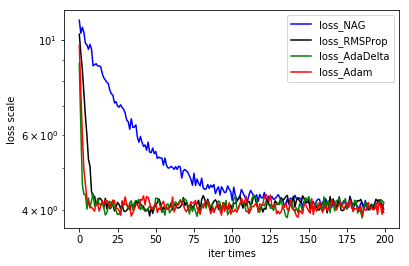

In [1]:
import numpy as np
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
#数据读取和分割
data = load_svmlight_file("a9a.txt")
x = data[0]
y = data[1]
x = x.toarray()
y = y.T
#补全X
add_num  = np.zeros(int(x.size/122))
x = np.column_stack([x,add_num])

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33, random_state=1)

#学习率、C、权重的设置
rating = 0.003
C = 0.9
weight = np.ones(124)
weight_NAG = weight
weight_RMSProp = weight
weight_AdaDelta = weight
weight_Adam = weight

#训练集和测试集的长度
train_length = int(x_train.size/123)
test_length = int(x_test.size/123)

#测试集和训练集的截距设置
weight0  = np.ones(train_length)
weight1  = np.ones(test_length)
x_train = np.column_stack([x_train,weight0])
x_test = np.column_stack([x_test,weight1])

#验证集的loss数组初始化
loss_test = np.array([])
loss_NAG = np.array([])
loss_RMSProp = np.array([])
loss_AdaDelta = np.array([])
loss_Adam = np.array([])

#累计Adam迭代次数
iter = 1

#定义分类器
def svm_classification(x,y,length,weight,rating,C,k,loss,ways,iter):
    #准确率计数
    temp = 0
    #四种优化方法的参数初始化
    jw = 0
    Vt_NAG = 0
    Gt_RMSProp = 0
    Gt_AdaDelta = 0
    theta_AdaDelta = 0
    delta_AdaDelta = 0
    Gt_Adam = 0
    Mt_Adam = 0
    alpha_Adam = 0
    epsilon = 0.00001
    
    #500批梯度下降
    for j in range(500):
        upsilon = 1 - np.dot(y[k + j],np.dot(weight.T,x[k + j].T))
        if(upsilon > 0):
            gradient = 1/C * weight + np.dot(x[k + j],y[k + j])
            #损失函数累加
            jw = jw + upsilon
        if(upsilon <= 0):
            gradient = 1/C * weight

        #NAG优化方法
        if(ways == 1):
            gradient = (gradient - 1/C * 0.9 * Vt_NAG)/500
            Vt_NAG = 0.9*Vt_NAG + rating * gradient
            weight =  weight - Vt_NAG
        #RMSProp优化方法
        if(ways == 2):
            gradient = gradient/500
            Gt_RMSProp = 0.9*Gt_RMSProp + 0.1*np.dot(gradient,gradient)
            weight =  weight - (rating/np.sqrt(Gt_RMSProp + epsilon)) * gradient
        #AdaDelta
        if(ways == 3):
            gradient = gradient/500
            Gt_AdaDelta = 0.95*Gt_AdaDelta + 0.05*np.dot(gradient,gradient)
            theta_AdaDelta = -np.dot((np.sqrt(delta_AdaDelta + epsilon)/np.sqrt(Gt_AdaDelta + epsilon)),gradient)
            weight =  weight + theta_AdaDelta
            delta_AdaDelta = 0.95*delta_AdaDelta + 0.05*np.dot(theta_AdaDelta,theta_AdaDelta)
        #Adam优化方法
        if(ways == 4):
            gradient = gradient/500
            Mt_Adam = 0.9*Mt_Adam + 0.1*gradient
            Gt_Adam = 0.999*Gt_Adam + 0.001*np.dot(gradient,gradient)
            alpha_Adam = rating*(np.sqrt(1-0.999/(np.sqrt(iter)))/(1-(0.9/np.sqrt(iter))))
            weight =  weight - alpha_Adam * (Mt_Adam/(np.sqrt(Gt_Adam + epsilon)))
            iter = iter + 1
        #预测值
        y_p = np.dot(weight.T,x[k + j].T)
        #验证预测结果(阈值设定，计算准确率)
        if(y_p > 6):
            y_predict = 1.0
        if(y_p <= 6):
            y_predict = -1.0
        if(y_predict == y[k + j]):
            temp = temp + 1
    #损失函数
    jw = np.dot(weight,weight)/2 + C * jw
    loss = np.append(loss,jw/500)
    return loss,weight

#训练和测试四种优化方法，并迭代200次
for i in range(200):
    loss_NAG,weight_NAG = svm_classification(x_test,y_test,test_length,weight_NAG,rating,C,np.random.randint(0,test_length - 502),loss_NAG,1,iter)
    loss_RMSProp,weight_RMSProp = svm_classification(x_test,y_test,test_length,weight_RMSProp,rating,C,np.random.randint(0,test_length - 502),loss_RMSProp,2,iter)
    loss_AdaDelta,weight_AdaDelta = svm_classification(x_test,y_test,test_length,weight_AdaDelta,rating,C,np.random.randint(0,test_length - 502),loss_AdaDelta,3,iter)
    loss_Adam,weight_Adam = svm_classification(x_test,y_test,test_length,weight_Adam,rating,C,np.random.randint(0,test_length - 502),loss_Adam,4,iter)


#图显示
plt.figure()
plt.yscale('log')
plt.gca().set_xlabel('iter times')
plt.gca().set_ylabel('loss scale')
#蓝色的为NAG，黑色的为RMSProp，绿色的为AdaDelta，红色的为Adam
plt.plot(loss_NAG,'blue',label='loss_NAG')
plt.plot(loss_RMSProp,'black',label='loss_RMSProp')
plt.plot(loss_AdaDelta,'green',label='loss_AdaDelta')
plt.plot(loss_Adam,'red',label='loss_Adam')
plt.legend()
plt.show()
